In [123]:
import bisect
import datetime
import random
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import _airnode_sim_utils

API3_PURPLE = '#7963B2'
API3_EMERALD = '#7CE3CB'

to_date_str = lambda ts: datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

In [2]:
file_patterns = [
    '../gas_prices_2020-03-11_2020-03-13_100%-sampling*',
    '../gas_prices_2020-03-13_2020-03-14_100%-sampling*'
]

df = _airnode_sim_utils.load_data(file_patterns)
df

340 total files.


,blockNum,timeStamp,txnID,gasPrice
0,9646854,1583884773,0x1eb4d0a5e7702cf65d4a2e49743989cfc39a005d7d70...,40.000000
1,9646854,1583884773,0x1906edf9ba5a06ad9870910892b4a34bc1d2fe3885ef...,10.000000
2,9646854,1583884773,0xd9867d0d23048a0a7afa255c411597aac87dde6b7c58...,10.000000
3,9646854,1583884773,0x0ce33d9fd0a59f3b9d8fe16c51c24bd5f1eea6b9f479...,10.000000
4,9646854,1583884773,0x6e27c8fe7fa22d438e635e7085d0f971ee4e0438638d...,12.000000
...,...,...,...,...
2311300,9666211,1584143961,0xf4a8a769fa52ff5e2e5de24e8fa0e064d4169220140a...,10.000000
2311301,9666211,1584143961,0x671c031fc4901d4e8af3ef0bd39183f44e733350170a...,10.000001
2311302,9666211,1584143961,0x5ac5b6b2f8d332bac977bd4234f48865af212f4c5c2f...,12.000000
2311303,9666211,1584143961,0x9101913acca25b62dfe36ec2ec71600be16b44c3df78...,10.000000


In [3]:
start_ts = df.iloc[0]['timeStamp']
end_ts = df.iloc[-1]['timeStamp']

print("PRECISE DATE RANGE")
print(f"Start:\t{to_date_str(start_ts)}")
print(f"End:\t{to_date_str(end_ts)}")

PRECISE DATE RANGE
Start:	2020-03-10 23:59:33
End:	2020-03-13 23:59:21


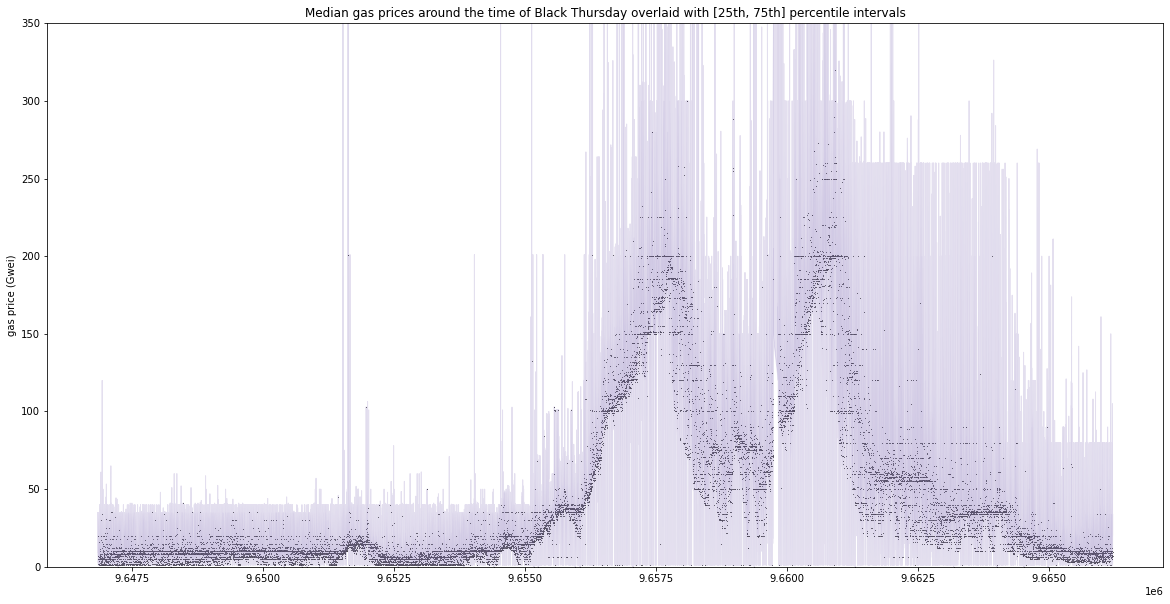

In [4]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

df_agg = df.groupby('blockNum')['gasPrice'].aggregate(
    ['median', 'mean', 'std', percentile(10), percentile(25), percentile(75), percentile(90)]
)
df_agg = df_agg.reset_index()

#df_agg = df_agg[(9646854 + 1000 <= df_agg['blockNum']) & (df_agg['blockNum'] < 9646854 + 1200)]

# overlay individual median points with [25, 75] percentile range
lower_bound = np.array(df_agg['percentile_10'])
upper_bound = np.array(df_agg['percentile_90'])

_, ax = plt.subplots(1, 1, figsize=(20,10))

g = sns.scatterplot(x="blockNum", y="median", data=df_agg, s=1, color="black")
plt.fill_between(df_agg['blockNum'], lower_bound, upper_bound, alpha=.2, color=API3_PURPLE);
plt.ylim(0, 350);

g.set(
    xlabel='',
    ylabel='gas price (Gwei)',
    #xticks=[df_agg['blockNum'].iloc[0], df_agg['blockNum'].iloc[-1]],
    #$xticklabels=[to_date_str(start_ts), to_date_str(end_ts)]
)

g.set_title(f'Median gas prices around the time of Black Thursday overlaid with [25th, 75th] percentile intervals');

# Run Airnode Sim

In [149]:
'''
We randomly select when the Airnode starts running.
To ensure enough historical blocks to compute recommended gas price, 
we start approx. 5 minutes after our historical data starts.
Similar reasoning for end time.
'''

airnode_start_ts = df.iloc[0]['timeStamp'] + random.randint(5 * 60, 6 * 60)
print(f'Airnode sim start time: {to_date_str(airnode_start_ts)}')

airnode_end_ts = df.iloc[-1]['timeStamp'] - random.randint(5 * 60, 6 * 60)
print(f'Airnode sim end time: {to_date_str(airnode_end_ts)}')

airnode_wake_up_times = range(airnode_start_ts, airnode_end_ts, 60)
gps = ['boosted_' + str(x) for x in np.arange(0.8, 1.6, 0.02)]
df_result = _airnode_sim_utils.airnode_sim(df, airnode_wake_up_times, gps)

df_result.to_csv('airnode_sim_results-boosted-black_thursday.csv', index=False)

Airnode sim start time: 2020-03-11 00:05:23
Airnode sim end time: 2020-03-13 23:54:03


In [150]:
df_result['gasPrice'] = df_result['gasPrice'].astype(float)
df_result['method'] = df_result['method'].apply(lambda s: s[:12])
df_result['boost_x'] = df_result['method'].apply(lambda s: float(re.match('boosted_(.+)', s).group(1)))
df_result.head()

,wakeup_ts,method,gasPrice,confirmation_block_num,confirmation_block_seconds,next_block_percentiles,boost_x
0,1583885126,boosted_0.8,4.0,1.0,13.0,"[1.0, 2.702722093, 5.0, 10.0, 88.0]",0.80
1,1583885126,boosted_0.82,4.1,1.0,13.0,"[1.0, 2.702722093, 5.0, 10.0, 88.0]",0.82
2,1583885126,boosted_0.84,4.2,1.0,13.0,"[1.0, 2.702722093, 5.0, 10.0, 88.0]",0.84
3,1583885126,boosted_0.86,4.3,1.0,13.0,"[1.0, 2.702722093, 5.0, 10.0, 88.0]",0.86
4,1583885126,boosted_0.88,4.4,1.0,13.0,"[1.0, 2.702722093, 5.0, 10.0, 88.0]",0.88


In [64]:
# TODO: reference notebook where these #s are gathered from
# they are used to have more "nuanced" results

In [155]:
def probability_mined_in_single_block(row):
    
    next_block_percentiles = list(map(float, row['next_block_percentiles']))
    
    mined_liklihood = {
        0:  0.098, # (0, 0]
        1:  0.844, # (0, 25]
        2:  0.938, # (25, 50]
        3:  0.955, # (50, 75]
        4:  0.974, # (75, 100]
        5:  1.0    # (100, 100]
    }
    key = bisect.bisect(next_block_percentiles, row['gasPrice'])
    return mined_liklihood[key]

In [156]:
# probability of getting mined for a single block
df_result['probability_mined'] = df_result.apply(
    probability_mined_in_single_block,
    axis=1
)
df_result

,wakeup_ts,method,gasPrice,confirmation_block_num,confirmation_block_seconds,next_block_percentiles,boost_x,probability_mined
0,1583885126,boosted_0.8,4.0,1.0,13.0,"[1.0, 2.702722093, 5.0, 10.0, 88.0]",0.80,0.938
1,1583885126,boosted_0.82,4.1,1.0,13.0,"[1.0, 2.702722093, 5.0, 10.0, 88.0]",0.82,0.938
2,1583885126,boosted_0.84,4.2,1.0,13.0,"[1.0, 2.702722093, 5.0, 10.0, 88.0]",0.84,0.938
3,1583885126,boosted_0.86,4.3,1.0,13.0,"[1.0, 2.702722093, 5.0, 10.0, 88.0]",0.86,0.938
4,1583885126,boosted_0.88,4.4,1.0,13.0,"[1.0, 2.702722093, 5.0, 10.0, 88.0]",0.88,0.938
...,...,...,...,...,...,...,...,...
619195,1584143606,boosted_1.50,15.0,3.0,58.0,"[5.0, 5.2, 7.0, 34.0, 34.0]",1.50,0.955
619196,1584143606,boosted_1.52,15.2,3.0,58.0,"[5.0, 5.2, 7.0, 34.0, 34.0]",1.52,0.955
619197,1584143606,boosted_1.54,15.4,3.0,58.0,"[5.0, 5.2, 7.0, 34.0, 34.0]",1.54,0.955
619198,1584143606,boosted_1.56,15.6,3.0,58.0,"[5.0, 5.2, 7.0, 34.0, 34.0]",1.56,0.955


In [157]:
def total_probability(x):
    
    def _get_total_probability(l, i):
        if i == len(l) - 1:
            return l[i]
        return l[i] + (1 - l[i]) * _get_total_probability(l, i + 1)
    
    return _get_total_probability(x.tolist(), 0)

def expected_confirmation_blocks(ps):
    
    def _get_expected_value(xs, ps, i):
        assert len(xs) == len(ps)
        if i == len(xs) - 1:
            return xs[i] * ps[i]
        return xs[i] * ps[i] + (1 - ps[i]) * _get_expected_value(xs, ps, i + 1)
    
    return _get_expected_value(list(range(1, len(ps) + 1)), ps.tolist(), 0)

In [158]:
df_probs = df_result.groupby(['wakeup_ts', 'boost_x']).agg({
    'probability_mined': [
        total_probability,
        expected_confirmation_blocks,
    ]
}, as_index=False).reset_index()
df_probs.columns = df_probs.columns.get_level_values(0)[:2].tolist() + df_probs.columns.get_level_values(1)[-2:].tolist()
df_probs

,wakeup_ts,boost_x,total_probability,expected_confirmation_blocks
0,1583885126,0.80,0.990328,1.042656
1,1583885126,0.82,0.990328,1.042656
2,1583885126,0.84,0.990328,1.042656
3,1583885126,0.86,0.990328,1.042656
4,1583885126,0.88,0.990328,1.042656
...,...,...,...,...
170835,1584143606,1.50,0.999970,1.026585
170836,1584143606,1.52,0.999970,1.026585
170837,1584143606,1.54,0.999970,1.026585
170838,1584143606,1.56,0.999970,1.026585


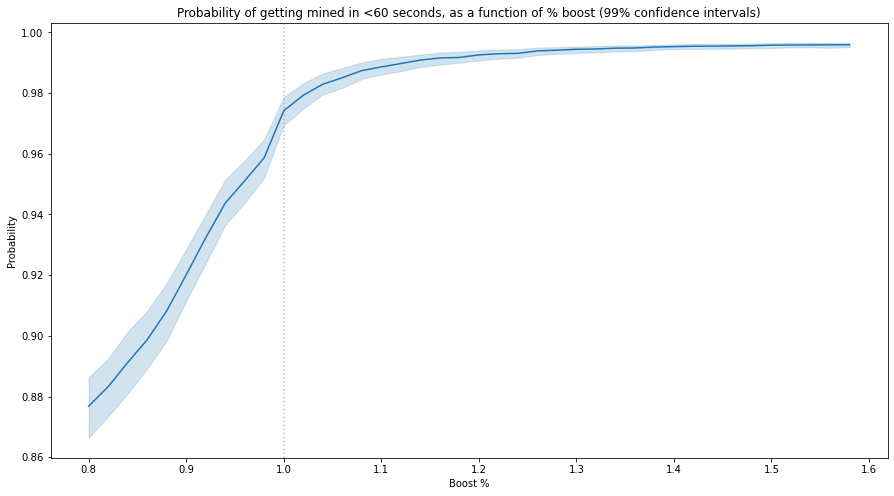

In [183]:
plt.figure(figsize=(15,8))
g = sns.lineplot(data=df_probs, x="boost_x", y="total_probability", ci=99)
plt.axvline(x=1, linestyle='dotted', color=(0.5, 0.5, 0.5, 0.5))
g.set(
    title='Probability of getting mined in <60 seconds, as a function of % boost (99% confidence intervals)',
    xlabel='Boost %',
    ylabel='Probability'
);

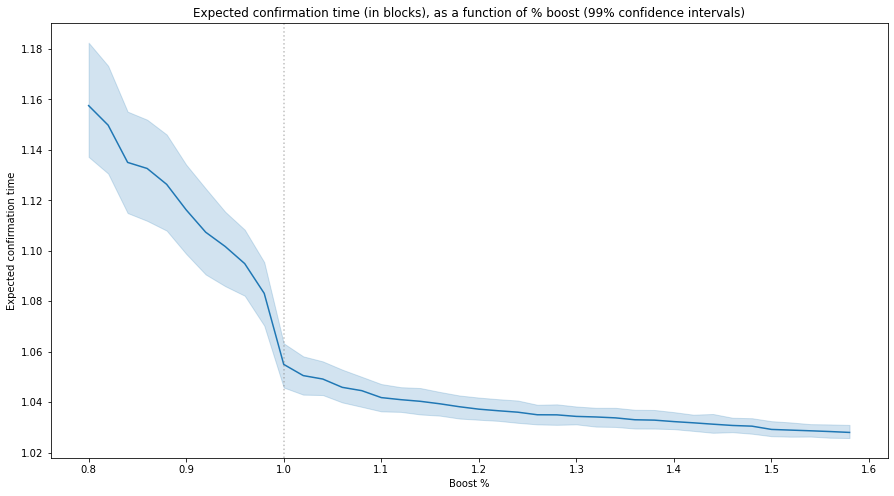

In [184]:
plt.figure(figsize=(15,8))
g = sns.lineplot(data=df_probs, x="boost_x", y="expected_confirmation_blocks", ci=99)
plt.axvline(x=1, linestyle='dotted', color=(0.5, 0.5, 0.5, 0.5))
g.set(
    title='Expected confirmation time (in blocks), as a function of % boost (99% confidence intervals)',
    xlabel='Boost %',
    ylabel='Expected confirmation time'
);

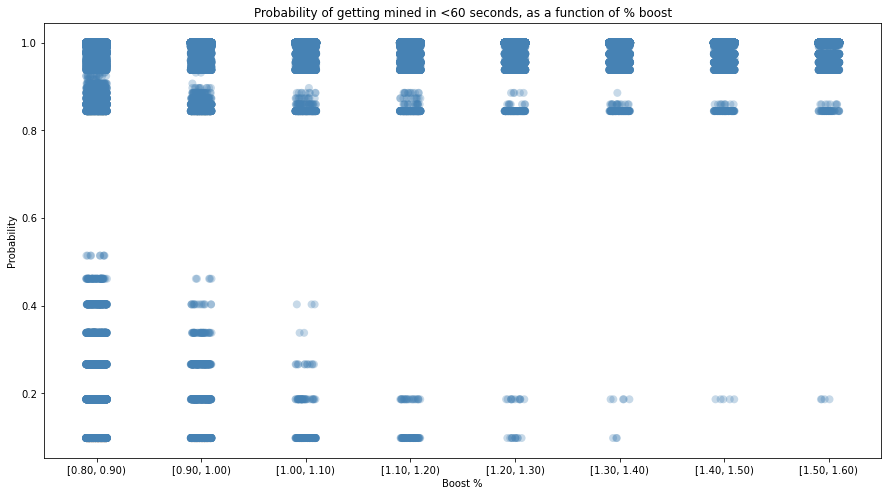

In [222]:
plt.figure(figsize=(15,8))

df_probs['boost_x_group'] = df_probs.boost_x.apply(lambda x: x // 0.1 / 10)

g = sns.stripplot(
    x="boost_x_group", y="total_probability", data=df_probs,
    size=8, alpha=0.3, color="steelblue"
);
g.set(
    title='Probability of getting mined in <60 seconds, as a function of % boost',
    xlabel='Boost %',
    ylabel='Probability',
    xticklabels=[
        f"[{x:.2f}, {(x + 0.1):.2f})" for x in sorted(df_probs['boost_x_group'].unique())
    ]
);

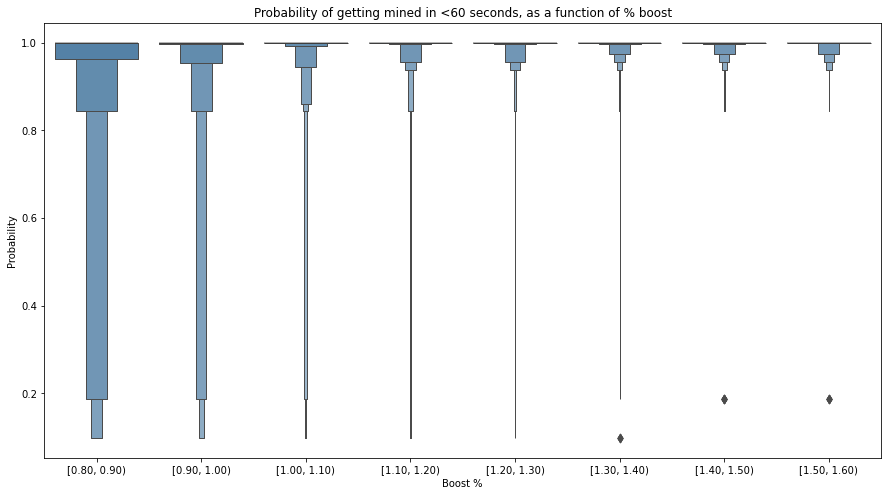

In [224]:
plt.figure(figsize=(15,8))
g = sns.boxenplot(
    x="boost_x_group", y="total_probability", data=df_probs,
    color="steelblue"
);
g.set(
    title='Probability of getting mined in <60 seconds, as a function of % boost',
    xlabel='Boost %',
    ylabel='Probability',
    xticklabels=[
        f"[{x:.2f}, {(x + 0.1):.2f})" for x in sorted(df_probs['boost_x_group'].unique())
    ]
);

## Measuring % improvement

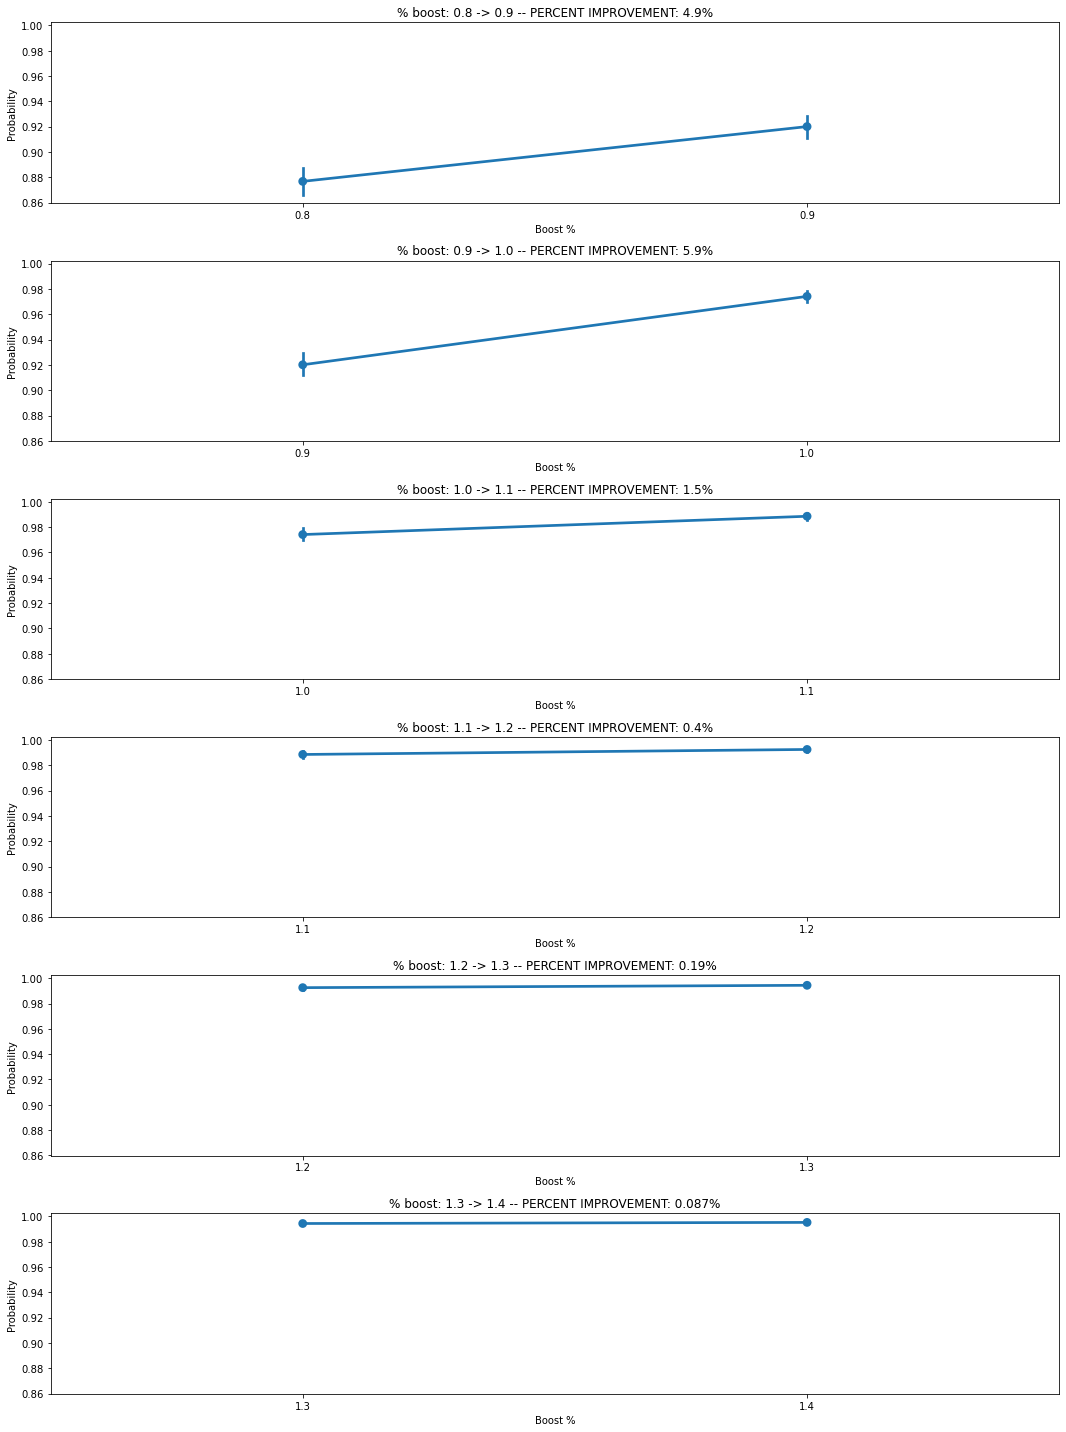

In [257]:
fig, axs = plt.subplots(6, sharey=True, figsize=(15,20))

l = df_probs['boost_x_group'].unique()
i = 0
while i < len(l) - 2:
    df_ = df_probs[df_probs['boost_x'].isin([l[i], l[i + 1]])]
    #plt.figure(figsize=(15,8))
    g = sns.pointplot(x="boost_x", y="total_probability", data=df_, ax=axs[i], ci=99)
    
    start_value = df_probs[df_probs['boost_x'] == l[i]].total_probability.mean()
    final_value = df_probs[df_probs['boost_x'] == l[i + 1]].total_probability.mean()
    
    percent_increase = (final_value - start_value) / start_value
    
    g.set(
        title=f'% boost: {l[i]} -> {l[i + 1]} -- PERCENT IMPROVEMENT: {100 * percent_increase:.2}%',
        xlabel='Boost %',
        ylabel='Probability',
    )
    i += 1
    
fig.tight_layout()
plt.show()

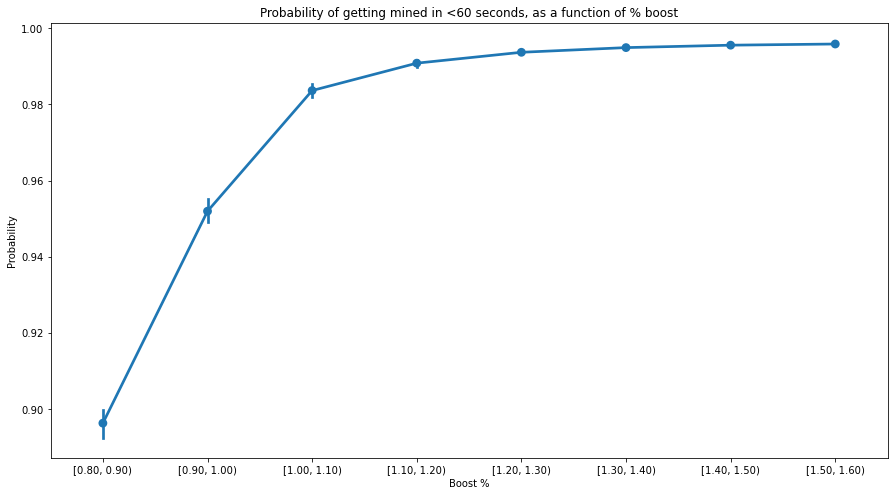

In [ ]:
for 

### Comments
- Interesting that there's a noticeable inflection point at 1.0 (i.e. == recommended gas price)

# TODO:
- catplot
- compare unmined

In [ ]:
import math
def _percentile(l, p):
    i = math.floor(len(l) * p / 100)
    i = min(len(l) - 1, i)
    return l[i]

In [ ]:
l = list(range(54543))

In [ ]:
_percentile(l, 50)